# ASTROPY FINAL PROJECT ASTR-19

Import numpy and sep

In [2]:
import numpy as np
import sep

Additional setup for reading the image and displaying plots

In [33]:
import astropy
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline
rcParams['figure.figsize'] = [10., 8.0]

Read the FITS file using astropy.io.fits.getdata()

In [4]:
data = fits.getdata("/Users/ChadFegley/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits")
data = data.byteswap(inplace=True).newbyteorder()

Display the image

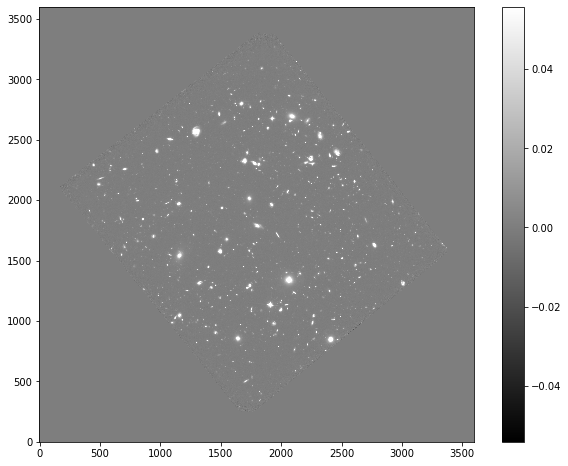

In [108]:
m = np.mean(data)
s = np.std(data)
plt.imshow(data, interpolation = 'nearest', cmap = 'gray', vmin = m - s, vmax = m + s, origin = 'lower')
plt.colorbar()
plt.savefig('fitsDataImage.png')

Measure a spatially varying background on the image

In [6]:
bkg = sep.Background(data)

Get a "global" mean and noise of the image background

In [7]:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


Evaluate the background as a 2-d array, same size as original image

In [8]:
bkg_image = bkg.back()

Display the background

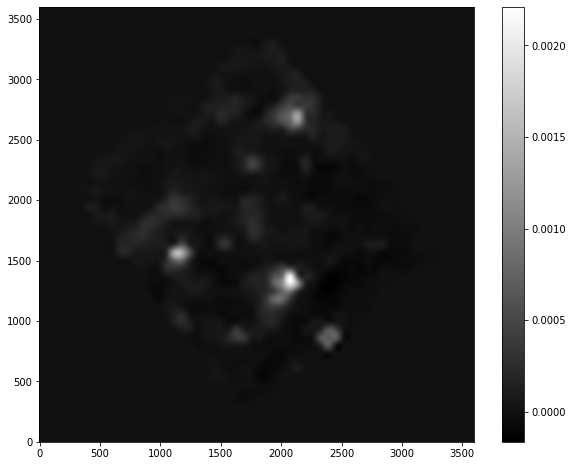

In [9]:
plt.imshow(bkg_image, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.savefig('displayBackground.png')

Evaluate the bakcground noise as a 2-d array, same size as original image

In [10]:
bkg_rms = bkg.rms()

Show the background noise

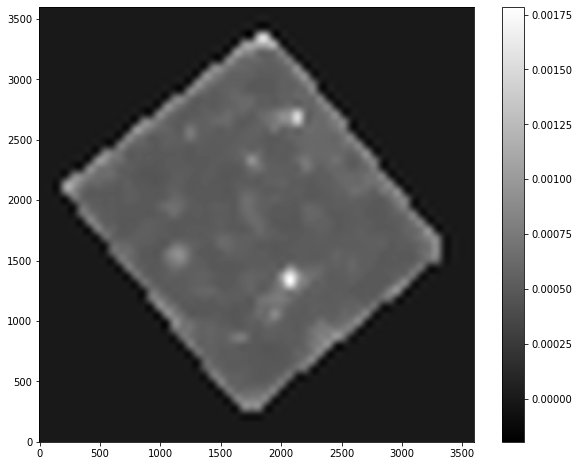

In [11]:
plt.imshow(bkg_rms, interpolation = 'nearest', cmap = 'gray', origin = 'lower')
plt.colorbar()
plt.savefig('backgroundNoise.png')

Subtract the background

In [12]:
data_sub = data - bkg

# OBJECT DETECTION

Since we have subtracted the background, we can run object detection on the subtracted data.

In [13]:
objects = sep.extract(data_sub, 1.5, err = bkg.globalrms)

Find out how many objects were detected

In [14]:
len(objects)

8646

objects['x'] and objects['y'] will give the centroid coordinates of the objects. Just to check where the detected objects are, we’ll over-plot the object coordinates with some basic shape parameters on the image:

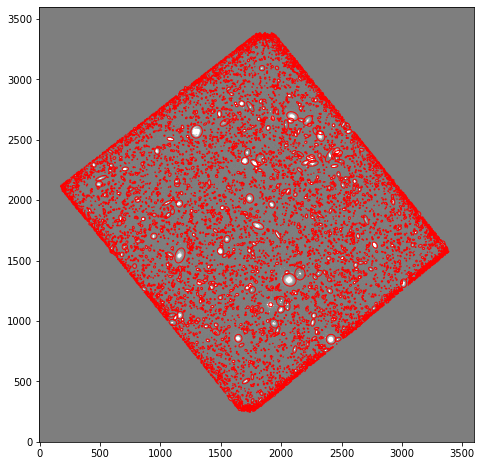

In [20]:
from matplotlib.patches import Ellipse

#Plot background subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation = 'nearest', cmap = 'gray',
              vmin = m - s, vmax = m + s, origin = 'lower')

#Plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy = (objects['x'][i], objects['y'][i]),
    width = 6 * objects['a'][i],
    height = 6 * objects['b'][i],
    angle = objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)

Perform simple circular aperture photometry witha 3 pixel radius at the locations of the objects

In [21]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                    3.0, err = bkg.globalrms, gain = 1.0)

In [22]:
for i in range(len(objects)):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
object 10: flux = 0.104682 +/- 0.323559
object 11: flux = 0.044953 +/- 0.212041
object 12: flux = 0.014043 +/- 0.118538
object 13: flux = 0.010265 +/- 0.101357
object 14: flux = 0.011400 +/- 0.106811
object 15: flux = 0.025562 +/- 0.159908
object 16: flux = 0.016498 +/- 0.128478
object 17: flux = -0.008420 +/- 0.002875
object 18: flux = 0.006981 +/- 0.083599
object 19: flux = 0.014791 +/- 0.121653
object 20: flux = -0.002137 +/- 0.002863
object 21: flux = 0.057425 +/- 0.239652
object 22: flux = -0.006278 +/- 0.002863
object 23: flux = 0.034407 +/- 0.185514
object 24: flux = 0.031591 +/- 0.177761
obje

Histmin: -2.0, Histmax: 809.0


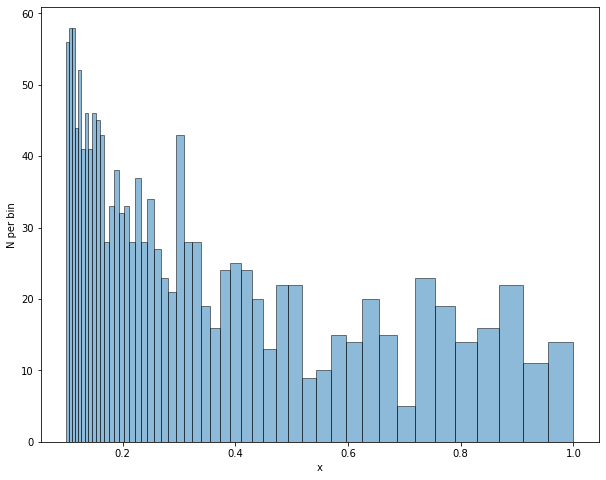

In [39]:
width = 1
histmin = np.floor(min(flux))
histmax = np.ceil(max(flux)) + width

bins = np.logspace(np.log10(0.1),np.log10(1.0), 50)
plt.hist(flux, bins=bins, alpha = 0.5, edgecolor = "black")
plt.ylabel("N per bin")
plt.xlabel("x")
plt.savefig('fluxHistogram.png')

print(f"Histmin: {histmin}, Histmax: {histmax}")

Now that we have made a histogram of the fluxes, we want to then get the mean, median, and standard deviation of the flux data.

In [40]:
fluxMean = np.mean(flux)
fluxMedian = np.median(flux)
fluxSTD = np.std(flux)

print(f"Flux Mean: {fluxMean}, Flux Median: {fluxMedian}, Flux STD: {fluxSTD}")

Flux Mean: 0.36159539075495284, Flux Median: 0.03097589430617518, Flux STD: 9.24028235192194


Now we want to identify the outliers of the flux data by creating a function that takes in the flux data and does some calculations to extract the outliers into their own array named "outliers".

In [56]:
outliers = []

def getOutliers(flux):
    
    threshold = 3
    firstMean = np.mean(flux)
    firstStand = np.std(flux)
    
    for x in flux:
        z_score = (x - firstMean) / firstStand
        if np.abs(z_score) > threshold:
            outliers.append(x)
    return outliers

outlierDataPoints = getOutliers(flux)
print(f"Outliers: {outlierDataPoints}")
print(f"The largest outlier is: 807.2972835731507")



Outliers: [72.33984953880311, 65.90718430519105, 807.2972835731507, 52.12667887449266, 45.75134319305421, 77.9742225933075, 55.936582095623024, 35.85189163804054, 34.961994493007666, 30.024165342450143, 214.1414422988892, 43.59707835912704, 80.5576771605015]
The largest outlier is: 807.2972835731507


In [66]:
fluxArray = []
for i in flux:
    fluxArray.append(i)
    
fluxArray.sort()

q1, q3 = np.percentile(fluxArray, [25,75])

iqr = q3 - q1

lowBound = q1 - (1.5 * iqr)
upBound = q3 + (1.5 * iqr)

print(f"Q1: {q1}, Q3: {q3}, IQR: {iqr}, Lower Bound: {lowBound}, Upper Bound: {upBound}")

Q1: 0.019380116573738632, Q3: 0.06882469519550796, IQR: 0.04944457862176933, Lower Bound: -0.05478675135891538, Upper Bound: 0.14299156312816197


# Make a 3-color false image

Download the f125w and f160w images of the HUDF and make a 3-color false image of the UDF using  RGB -> f160w, f125w, f105w

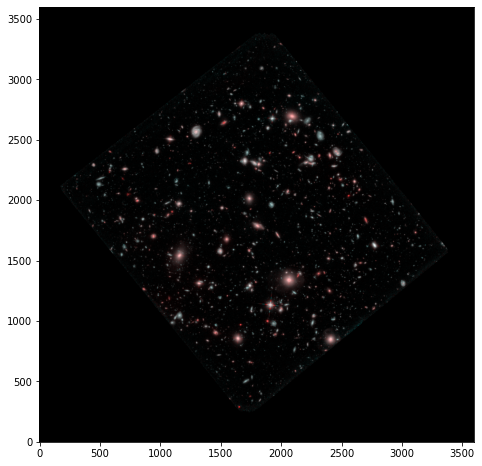

In [111]:
from astropy.visualization import make_lupton_rgb
from astropy.utils.data import get_pkg_data_filename

f105_data = get_pkg_data_filename('/Users/ChadFegley/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
f125_data = get_pkg_data_filename('/Users/ChadFegley/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits')
f160_data = get_pkg_data_filename('/Users/ChadFegley/Downloads/hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits')

f105 = fits.open(f105_data)[0].data
f125 = fits.open(f105_data)[0].data
f160 = fits.open(f160_data)[0].data


rgb = make_lupton_rgb(f160, f125, f105, Q=7, stretch=0.02, filename="ngc6976.jpeg")
plt.imshow(rgb, origin='lower')
plt.savefig('threeColorFalseImage.png')